# Aubrey Andre Model

The Hamiltonian is given by
$$
\mathcal{H} = -J \sum_{n} (|n\rangle \langle n+1| + |n+1\rangle \langle n|) + \sum_{n} \epsilon_n |n\rangle \langle n|
$$
where sum is running over all the lattice points. $J$ is the hopping energy, and the on-site energies $\epsilon_{n}$ are given by
$$
\epsilon_n = \lambda \cos(2\pi \beta n + \varphi)
$$
Here $\lambda$ is the amplitude of the variation of the onsite energies, $\varphi$ is a relative phase, and $\beta$ is the period of the onsite potential modulation in units of the lattice constant (and if $\beta$ is irrational we have some amazing results as well [based choice is `Golden Ratio`]).

Let we have a chain of $N$ sites. The Hamiltonian can be written in the matrix form as
$$
\mathcal{H} = \begin{pmatrix}
\epsilon_1 & -J & 0 & \cdots & 0 & 0 & -J \\
-J & \epsilon_2 & -J  & \cdots & 0 & 0 & 0 \\
0 & -J & \epsilon_3  & \cdots & 0 & 0 & 0 \\
\vdots & \vdots  & \vdots & \ddots & \vdots & \vdots & \vdots \\
0 & 0 & 0 & \cdots & \epsilon_{N-2} & -J & 0 \\
0 & 0 & 0 & \cdots & -J & \epsilon_{N-1} & -J \\
-J & 0 & 0 & \cdots & 0 & -J & \epsilon_N
\end{pmatrix}_{N \times N}
$$

In [1]:
# again, this only works on startup!
import jax
jax.config.update("jax_enable_x64", True)

In [63]:
from functools import partial
import seaborn as sns
import matplotlib.colors as colors
import numpy as np
import jax.numpy as jnp
# import scipy as sp
import jax.scipy as jsp
import scipy.constants as const
import sympy as sym

import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science', 'notebook', 'grid'])

### Definition of the Hamiltonian

In [3]:
@partial(jax.jit, static_argnames=("L",))
def aubry_andre_hamiltonian(L, J, λ, β, φ):
    """
    Generates the Aubry-André Hamiltonian matrix.

    Parameters:
    L (int): The size of the system (number of lattice sites).
    J (float): Hopping amplitude between nearest-neighbor sites.
    λ (float): Strength of the quasiperiodic potential.
    β (float): Irrational number (commonly taken as the inverse of the golden ratio).
    φ (float): Phase parameter of the potential.

    Returns:
    jnp.ndarray: The Hamiltonian matrix of size LxL.
    """
    # Generate the diagonal elements
    diag = λ * jnp.cos(2 * jnp.pi * β * jnp.arange(1, L+1) + φ)
    # Generate the off-diagonal elements
    off_diag = -J * jnp.ones(L - 1)
    # Generate the Hamiltonian
    H = jnp.diag(diag) + jnp.diag(off_diag, k=1) + jnp.diag(off_diag, k=-1)
    return H

In [4]:
# Example usage
L = 10  # Size of the system
J = 1.0  # Hopping amplitude
λ = 1  # Potential strength
β = const.golden_ratio  # Inverse of the golden ratio
φ = 0.0  # Phase parameter

H = aubry_andre_hamiltonian(L, J, λ, β, φ)
sym.Matrix(H)
# H

Matrix([
[-0.73736887807832,               -1.0,               0.0,                0.0,               0.0,                0.0,                0.0,               0.0,                0.0,               0.0],
[             -1.0, 0.0874257247169617,              -1.0,                0.0,               0.0,                0.0,                0.0,               0.0,                0.0,               0.0],
[              0.0,               -1.0, 0.608438860978861,               -1.0,               0.0,                0.0,                0.0,               0.0,                0.0,               0.0],
[              0.0,                0.0,              -1.0, -0.984713485315428,              -1.0,                0.0,                0.0,               0.0,                0.0,               0.0],
[              0.0,                0.0,               0.0,               -1.0, 0.843755294812401,               -1.0,                0.0,               0.0,                0.0,               0.0],
[     

### Time evolution of the state

In [5]:
@partial(jax.jit, static_argnames=("n_steps",))
def time_evolution(H: jnp.ndarray, psi: jnp.ndarray, t: jnp.float64, n_steps: int = 100):
    """
    Time-evolves a state under a given Hamiltonian.

    Parameters:
    H (jnp.ndarray): The Hamiltonian matrix.
    psi (jnp.ndarray): The initial state vector.
    t (float): The time to evolve the state to.
    n_steps (int): The number of steps to use in the Trotter-Suzuki approximation.

    Returns:
    jnp.ndarray: The state vector evolved to time t.
    """
    dt = t / n_steps

    Udt = jsp.linalg.expm(-1j * H * dt)

    U = jnp.linalg.matrix_power(Udt, n_steps)

    return jnp.linalg.matmul(U, psi)

In [6]:
ψ = jnp.ones(4)
ψ = ψ / jnp.linalg.norm(ψ)
ψ

Array([0.5, 0.5, 0.5, 0.5], dtype=float64)

In [7]:
I4 = jnp.eye(4)
I2 = jnp.eye(2)

X = jnp.array([[0, 1], [1, 0]])
Z = jnp.array([[1, 0], [0, -1]])

H_CNOT = (jnp.kron(Z, I2) - I4) @ (I4 - jnp.kron(I2, X))
sym.Matrix(H_CNOT)

Matrix([
[0.0, 0.0,  0.0,  0.0],
[0.0, 0.0,  0.0,  0.0],
[0.0, 0.0, -2.0,  2.0],
[0.0, 0.0,  2.0, -2.0]])

In [8]:
sym.Matrix(jsp.linalg.expm(-1j * H_CNOT * jnp.pi / 4))

Matrix([
[1.0,   0,                                              0,                                             0],
[  0, 1.0,                                              0,                                             0],
[  0,   0, -1.88705684543524e-16 + 1.72299281361403e-16*I,                  1.0 - 6.12507284459122e-17*I],
[  0,   0,                   1.0 - 2.42428550020154e-16*I, 1.27323402213925e-16 + 1.50177581248445e-16*I]])

In [9]:
ϕ = time_evolution(H_CNOT, ψ, jnp.pi/4, 100)
ϕ

Array([0.5+0.00000000e+00j, 0.5+0.00000000e+00j, 0.5-1.98289372e-15j,
       0.5+2.06616044e-15j], dtype=complex128)

In [10]:
sym.Matrix(ϕ)

Matrix([
[                                       0.5],
[                                       0.5],
[0.500000000000015 - 1.98289371674753e-15*I],
[0.500000000000016 + 2.06616044359443e-15*I]])

### Measurement of the state

In [11]:
# @partial(jax.jit)
def wavefunction_after_measurement(psi: jnp.ndarray, site: int):
    """
    Computes the wavefunction after a measurement.

    Parameters:
    psi (jnp.ndarray): The initial state vector.
    site (int): The measurement outcome.

    Returns:
    jnp.ndarray: The state vector after the measurement.
    """
    # key = jax.random.key(42)

    site -= 1
    # phi = jnp.zeros(len(psi))
    p = jnp.abs(psi[site])**2
    if p < 1e-5:
        p = 0

    r = np.random.rand()
    if r <= p:
        phi = jnp.zeros(len(psi))
        phi = phi.at[site].set(1)
    else:
        phi = psi.copy()
        phi = phi.at[site].set(0)
        phi = phi / np.linalg.norm(phi)

    return phi

In [12]:
wavefunction_after_measurement(ψ, 1)

Array([0.        , 0.57735027, 0.57735027, 0.57735027], dtype=float64)

### Combining evolution and measurement

Here we have used both the function `time_evolution` and `wavefunction_after_measurement` to get the final wavefunction after $N$ generations.

In [13]:
def time_evolve_with_measurement(H, psi, t, n_steps, generations):
    # psi = psi.copy()
    for _ in range(generations):
        psi = time_evolution(H, psi, t, n_steps)
        psi = wavefunction_after_measurement(
            psi, np.random.randint(1, len(psi)+1))

    return psi

#### Example for a simple Aubrey Andre Chain

The Hamiltonian is given by
$$
\mathcal{H} = -J \sum_{n} (|n\rangle \langle n+1| + |n+1\rangle \langle n|) + \sum_{n} \epsilon_n |n\rangle \langle n|
$$
where sum is running over all the lattice points. $J$ is the hopping energy, and the on-site energies $\epsilon_{n}$ are given by
$$
\epsilon_n = \lambda \cos(2\pi \beta n + \varphi)
$$
Here $\lambda$ is the amplitude of the variation of the onsite energies, $\varphi$ is a relative phase, and $\beta$ is the period of the onsite potential modulation in units of the lattice constant (and if $\beta$ is irrational we have some amazing results as well [based choice is `Golden Ratio`]).

\begin{gather*}
L = 101 \\
N = 300 \\
J = 1 \\
\lambda = 1 \\
\beta = \phi ~(\text{Golden Ratio}) \\
\varphi = 0 \\
\text{Initial State} = |51\rangle \\
\end{gather*}

where $L$ is the number of lattice points and $N$ is the number of generations.

In [14]:
H_AA = aubry_andre_hamiltonian(101, 1.0, 1.0, const.golden_ratio, 0.0)

In [15]:
psi = jnp.zeros(101).at[50].set(1)

In [16]:
phi = time_evolve_with_measurement(H_AA, psi, 1, 100, 300)

In [17]:
sym.Matrix(phi)

Matrix([
[ -0.148855055092757 - 0.00362346737532519*I],
[  0.0801519813556373 - 0.0477478145841887*I],
[ -0.0257046060939632 + 0.0148002439003639*I],
[ -0.0136276791736312 + 0.0637476835421554*I],
[-0.00154677716951324 - 0.0470156645937517*I],
[-0.0381286764589326 + 0.00608999251459054*I],
[  0.148918161330627 - 0.00207857009744777*I],
[ -0.0241672989529041 - 0.0749115068732888*I],
[  -0.030870138040634 - 0.0204951545026837*I],
[    0.04065459151721 - 0.0142866022423274*I],
[ -0.0610413697110476 - 0.0367478023491433*I],
[ -0.0239916273735602 + 0.0578060986372217*I],
[-0.00237528992455934 + 0.0142250053561077*I],
[-0.00881905923426014 - 0.0668321438036384*I],
[  -0.0351218122611953 + 0.041475902854501*I],
[  0.0267471197853457 + 0.0427822197757529*I],
[  0.0601184633413239 + 0.0330097377583702*I],
[  -0.042381234567763 + 0.0247472180700487*I],
[  0.0453380850751285 - 0.0748655170363823*I],
[ 0.00427081399042546 - 0.0512494508026645*I],
[ -0.0630469660640585 + 0.0991594127952013*I],
[  -

## Results

In [18]:
@jax.jit
def probability_distribution(psi):
    return jnp.abs(psi)**2

In [19]:
def spacetime_probability_distribution(H, psi, t, n_steps, generations):
    prob = []
    prob.append(probability_distribution(psi))
    for _ in range(generations):
        psi = time_evolution(H, psi, t, n_steps)
        psi = wavefunction_after_measurement(
            psi, np.random.randint(1, len(psi)+1))
        prob.append(probability_distribution(psi))

    return np.array(prob)

In [70]:
H_AA = aubry_andre_hamiltonian(101, 1.0, 1.0, const.golden_ratio, 0.0)
psi = jnp.zeros(101).at[50].set(1)

In [71]:
prob = spacetime_probability_distribution(H_AA, psi, 1, 100, 300)

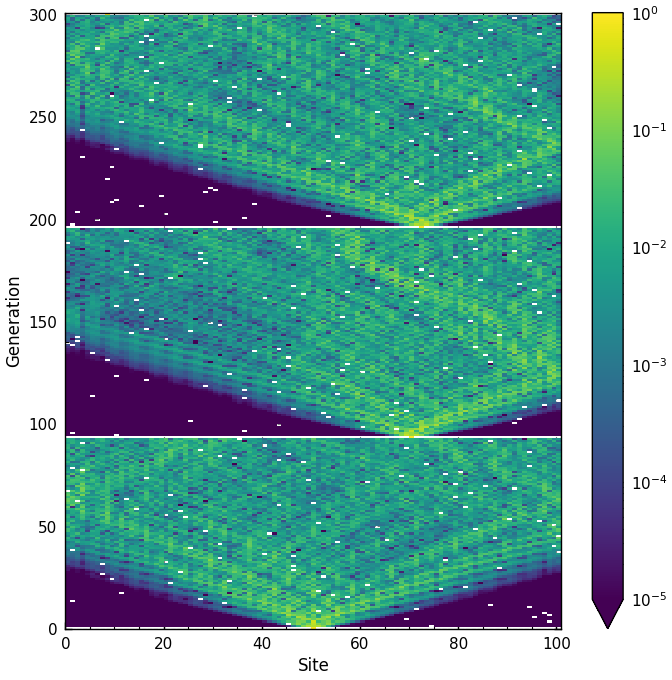

In [72]:
fig, ax = plt.subplots(figsize=(8, 8))
pc = ax.pcolormesh(prob, cmap='viridis',
                   norm=colors.LogNorm(vmin=1e-5, vmax=1), shading='auto')
fig.colorbar(pc, ax=ax, extend='min')
ax.set_xlabel("Site")
ax.set_ylabel("Generation")
plt.savefig("spacetime_probability_distribution-LogScale.png",
            dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()
# savefig()

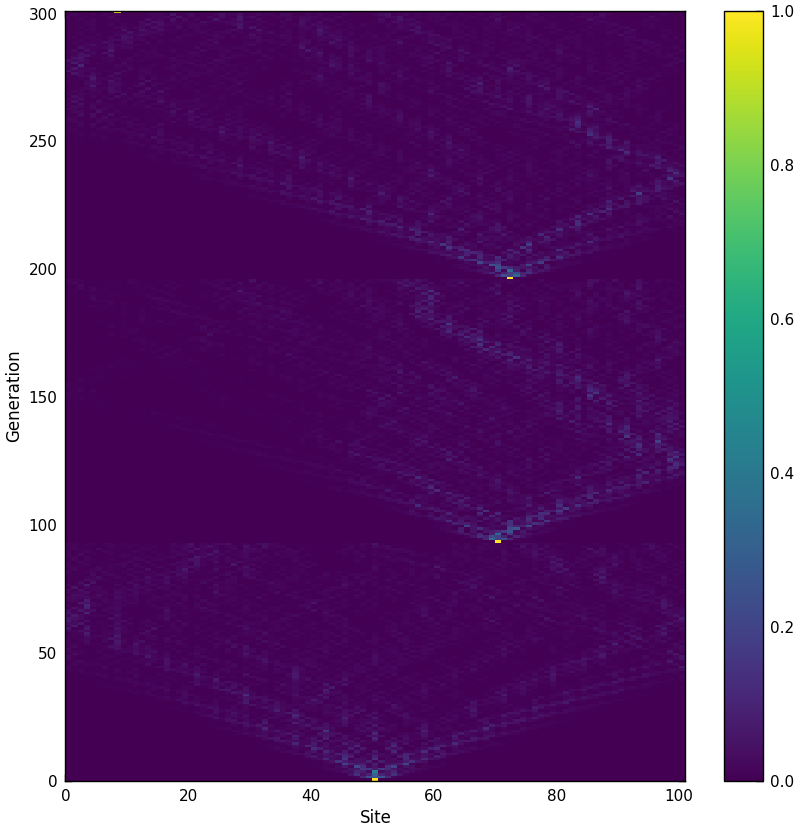

In [73]:
fig, ax = plt.subplots(figsize=(10, 10))
pc = ax.pcolormesh(prob, cmap='viridis', shading='auto')
fig.colorbar(pc, ax=ax)
ax.set_xlabel("Site")
ax.set_ylabel("Generation")
plt.savefig("spacetime_probability_distribution-Normal.png",
            dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

<Axes: >

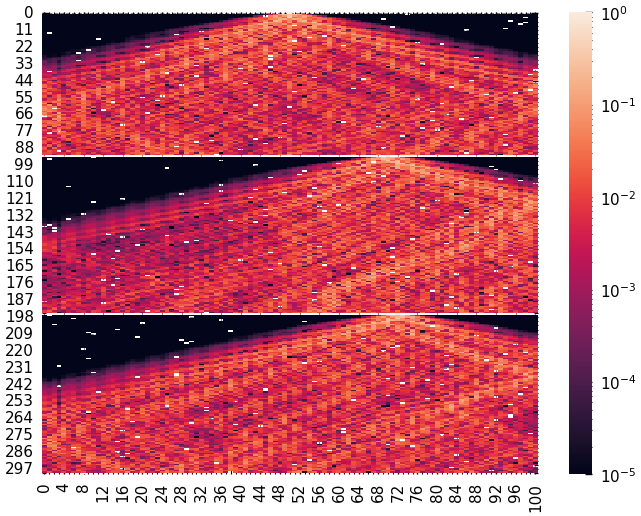

In [74]:
sns.set_context("paper", font_scale=1.25)
sns.heatmap(prob, norm=colors.LogNorm(vmin=1e-5, vmax=1), robust=True)